# Normal Model and Synthetic Data

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import pandas as pd
import matplotlib.pyplot as plt
from famo.core import CORE
from famo.plotting import plot_variance_explained
from utils import generate_data
from utils import match

warnings.simplefilter(action="ignore", category=FutureWarning)

## Data Generation

In [2]:
data = generate_data(
    n_samples={"group_1" : 1000, "group_2" : 1200},
    n_features={"view_1" : 200, "view_2" : 250},
    n_factors=3,
    likelihoods={"view_1" : "Normal", "view_2" : "Normal"},
)

## Model Fitting

In [ ]:
# Run model with MuData object
model = CORE(device="cuda")
model.fit(
    n_factors=3, 
    data=data,
    factor_prior="Horseshoe",
    weight_prior="ARD_Spike_and_Slab",
    lr=0.005,
    early_stopper_patience=500,
    print_every=500,
    center_groups=True,
    scale_views=False,
    scale_groups=True,
    max_epochs=10000,
    init_factors="random",
    init_scale=0.1,
    save=False,
)

## Variance Explained Analysis

In [7]:
plot_variance_explained(model)

alt.HConcatChart(...)

## Assignment of Inferred to True Factors

In [8]:
group = "group_1"
view = "view_1"

w = model.get_weights("pandas")[view]
z = model.get_factors("pandas")[group]

w_gt = pd.DataFrame(data[group][view].varm["w"].T, columns=data[group][view].var_names)
z_gt = pd.DataFrame(data[group][view].obsm["z"], index=data[group][view].obs_names)

z_common_indices = z.index.intersection(z_gt.index)
z = z.loc[z_common_indices].sort_index(axis=0)
z_gt = z_gt.loc[z_common_indices].sort_index(axis=0)

w_common_cols = w.columns.intersection(w_gt.columns)
w = w.loc[:, w_common_cols]
w_gt = w_gt.loc[:, w_common_cols]

w = w.sort_index(axis=1)
w_gt = w_gt.sort_index(axis=1)

inds, signs = match(z_gt.values, z.values, dim=-1)

z = z.iloc[:, inds] * signs
w = w.iloc[inds] * signs.reshape(-1, 1)

## Correlation Plots

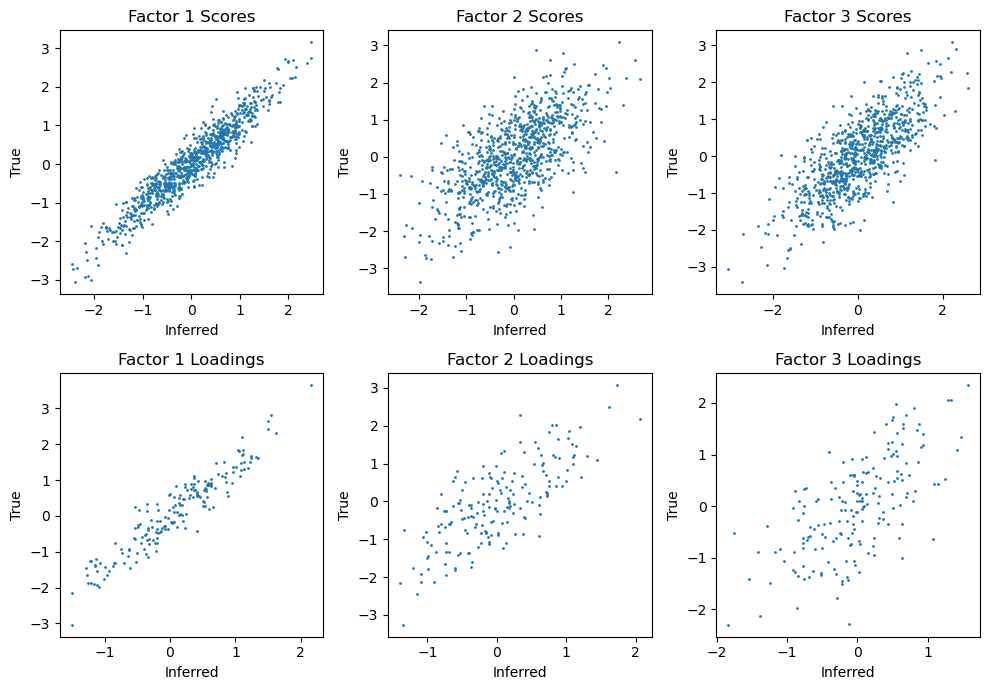

In [9]:
fig, axs = plt.subplots(2, z.shape[1], figsize=(10, 7))
for i in range(z.shape[1]):
    axs[0, i].scatter(z.iloc[:, i], z_gt.iloc[:, i], s=1)
    axs[1, i].scatter(w.iloc[i], w_gt.iloc[i], s=1)
    axs[0, i].set_title(f"Factor {i + 1} Scores")
    axs[1, i].set_title(f"Factor {i + 1} Loadings")

for ax in axs.flatten():
    ax.set_xlabel("Inferred")
    ax.set_ylabel("True")

plt.tight_layout()